# Example with high-resolution CMIP6 models (~100 km) using Pangeo catalog 


# Table of Contents
<ul>
<li><a href="#introduction">1. Introduction</a></li>
<li><a href="#data_wrangling">2. Data Wrangling</a></li>
<li><a href="#exploratory">3. Exploratory Data Analysis</a></li>
<li><a href="#conclusion">4. Conclusion</a></li>
<li><a href="#references">5. References</a></li>
</ul>



# 1. Introduction <a id='introduction'></a>
Cloud feedbacks are a major contributor to the spread of climate sensitivity in global climate models (GCMs) [Zelinka et al. (2020)](https://doi-org.ezproxy.uio.no/10.1029/2019GL085782). Among the most poorly understood cloud feedbacks is the one associated with the cloud phase, which is expected to be modified with climate change [Bjordal et al. (2020)](https://doi-org.ezproxy.uio.no/10.1038/s41561-020-00649-1). Cloud phase bias, in addition, has significant implications for the simulation of radiative properties and glacier and ice sheet mass balances in climate models. 

In this context, this work aims to expand our knowledge on how the representation of the cloud phase affects snow formation in GCMs. Better understanding this aspect is necessary to develop climate models further and improve future climate predictions. 

* Retrieve CMIP6 data through [Pangeo](https://pangeo-data.github.io/pangeo-cmip6-cloud/)
* Hybrid sigma-pressure coordinates to isobaric pressure levels of the European Centre for Medium-Range Weather Forecast Re-Analysis 5 (ERA5) with [GeoCAT-comb](https://geocat-comp.readthedocs.io/en/latest/index.html)
* Regridd the CMIP6 variables to the exact horizontal resolution with [`xesmf`](https://xesmf.readthedocs.io/en/latest/)
* Calculate an ensemble mean of all used models
* Calculate and plot the seasonal mean of the ensemble mean

**Questions**
* How is the cloud phase and snowfall varying between 1985 and 2014?

> **_NOTE:_** We answer questions related to the comparison of CMIP models to ERA5 in another [Jupyter Notebook](../CMIP6_ERA5_CloudSat/plt_seasonal_mean.ipynb).

# 2. Data Wrangling <a id='data_wrangling'></a>

This study will compare surface snowfall, ice, and liquid water content from the Coupled Model Intercomparison Project Phase 6 ([CMIP6](https://esgf-node.llnl.gov/projects/cmip6/)) climate models (accessed through [Pangeo](https://pangeo.io/)) to the European Centre for Medium-Range Weather Forecast Re-Analysis 5 ([ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5)) data from **1985 to 2014**. We conduct statistical analysis at the annual and seasonal timescales to determine the biases in cloud phase and precipitation (liquid and solid) in the CMIP6 models and their potential connection between them. 

- Time period: 1985 to 2014
- horizonal resolution: ~100km
- time resolution: monthly atmospheric data (Amon, AERmon)
- Variables:
  
| shortname     |             Long name                   |      Units    |  levels |
| ------------- |:---------------------------------------:| -------------:|--------:|
|  prsn         |    Snowfall Flux                        | [kg m-2 s-1]  | surface |
| clw           |    Mass Fraction of Cloud Liquid Water  |  [kg kg-1]    |    ml   | 
|               |                                         | to calculate lwp use integral clw -dp/dg | |
| cli           |    Mass Fraction of Cloud Ice           | [kg kg-1]     |    ml   |
| tas           |    Near-Surface Air Temperature         |   [K]         | surface |
| ta            |    Air Temperature                      |  [K]          |  plev   |
| clivi         |    Ice Water Path                       | [kg m-2]      |         |
| lwp           |    Liquid Water Path                    | [kg m-2]      |         |
| pr            |    Precipitation                        | [kg m-2 s-1]  | surface |

- CMIP6 models:

| Institution                                            |     Model name    | Reference                                                     |
| ------------------------------------------------------ |:-----------------:|--------------------------------------------------------------:|
| [AS-RCEC](https://www.rcec.sinica.edu.tw/index_en.php) | TaiESM1           | [Lee et al. (2020)](https://doi.org/10.5194/gmd-13-3887-2020) |
| [BCC](http://bcc.ncc-cma.net/)                         | BCC-CSM2-M        | [Wu et al. (2019)](https://doi.org/10.5194/gmd-12-1573-2019)  |
| [CAMS](http://www.cma.gov.cn/en2014/)                  | CAMS-CSM1-0       |                                                               |
| [CAS](http://english.iap.cas.cn/)                      | FGOALS-f3-L       | [Bian et al. (2020)](https://doi-org.ezproxy.uio.no/10.1080/16742834.2020.1778419) |
| [CMCC](https://www.cmcc.it/)                           | CMCC-CM2-SR5      | [Cherchi et al. (2019)](https://doi-org.ezproxy.uio.no/10.1029/2018MS001369)|
|                                                        | CMCC-CM2-HR4      | [Cherchi et al. (2019)](https://doi-org.ezproxy.uio.no/10.1029/2018MS001369)|
|                                                        | CMCC-ESM2         | [CMCC website](https://www.cmcc.it/models/cmcc-esm-earth-system-model)    |
| [EC-Earth-Consortium](http://www.ec-earth.org/)        | EC-Earth3-AerChem | [van Noije et al. (2021)](https://doi.org/10.5194/gmd-14-5637-2021)  |
| [E3SM-Project](https://e3sm.org/)                      | E3SM-1-1          | [Golaz et al. (2019)](https://doi-org.ezproxy.uio.no/10.1029/2018MS001603); [Burrows et al. (2020)](https://doi-org.ezproxy.uio.no/10.1029/2019MS001766) Text S8|
|                                                        | E3SM-1-1-ECA      | |
| [MPI-M](https://mpimet.mpg.de/en/homepage)             | MPI-ESM1-2-HR     | [Müller et al. (2018)](https://doi-org.ezproxy.uio.no/10.1029/2017MS001217)|
| [MRI](https://www.mri-jma.go.jp/index_en.html)         | MRI-ESM2-0        | [Yukimoto et al. (2019)](https://doi.org/10.2151/jmsj.2019-051) |
| [NCC](https://folk.uib.no/ngfhd/EarthClim/index.htm)   | NorESM2-MM        | [Seland et al. (2020)](https://doi.org/10.5194/gmd-13-6165-2020)|
| [NOAA-GFDL](https://www.gfdl.noaa.gov/)                | GFDL-CM4          | [Held et al. (2019)](https://doi-org.ezproxy.uio.no/10.1029/2019MS001829) |
|                                                        | GFDL-ESM4         | [Dunne et al. (2020)](https://doi-org.ezproxy.uio.no/10.1029/2019MS002015) |
| [SNU](https://en.snu.ac.kr/index.html)                 | SAM0-UNICON       | [Park et al. (2019)](https://doi-org.ezproxy.uio.no/10.1175/JCLI-D-18-0796.1) |
| [THU](https://www.tsinghua.edu.cn/en/)                 | CIESM             | [Lin et al. (2020)](https://doi-org.ezproxy.uio.no/10.1029/2019MS002036) |


## Organize my data

- Define a prefix for my project (you may need to adjust it for your own usage on your infrastructure).
    - input folder where all the data used as input to my Jupyter Notebook is stored (and eventually shared)
    - output folder where all the results to keep are stored
    - tool folder where all the tools

The ERA5 0.25deg data is located in the folder `/input/cmip6_hist/daily_means`.


In [1]:
import os
import pathlib
import sys
import socket
hostname = socket.gethostname()

abs_path = str(pathlib.Path(hostname).parent.absolute())
WORKDIR = abs_path[:- (len(abs_path.split('/')[-2] + abs_path.split('/')[-1])+1)]


if "mimi" in hostname:
    print(hostname)
    DATA_DIR = "/scratch/franzihe/"
    FIG_DIR = "/uio/kant/geo-metos-u1/franzihe/Documents/Figures/CMIP6/"
elif "glefsekaldt" in hostname: 
    DATA_DIR = "/home/franzihe/Data/"
    FIG_DIR = "/home/franzihe/Documents/Figures/CMIP6/"

INPUT_DATA_DIR = os.path.join(DATA_DIR, 'input')
OUTPUT_DATA_DIR = os.path.join(DATA_DIR, 'output')
UTILS_DIR = os.path.join(WORKDIR, 'utils')

sys.path.append(UTILS_DIR)
# make figure directory
try:
    os.mkdir(FIG_DIR)
except OSError:
    pass

mimi.uio.no


## Import python packages
- `Python` environment requirements: file [requirements_globalsnow.txt](../../requirements_globalsnow.txt) 
- load `python` packages from [imports.py](../../utils/imports.py)
- load `functions` from [functions.py](../../utils/functions.py)


In [2]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

# import packages
from imports import (xr, intake, cftime, xe, glob, np, cm, pd, fct,ccrs, cy, plt, da, gc, datetime)
xr.set_options(display_style="html")

In [3]:
# reload imports
%load_ext autoreload
%autoreload 2

## Open CMIP6 variables
Get the data required for the analysis. Beforehand we downloaded the daily averaged data on single levels and model levels via.

In [4]:
cmip_in = os.path.join(INPUT_DATA_DIR, 'cmip6_hist/daily_means')
cmip_out = os.path.join(OUTPUT_DATA_DIR, 'cmip6_hist/daily_means/common_grid')

# make output data directory
try:
    os.mkdir(cmip_out)
except OSError:
    pass

In [5]:
variable_id = ['clw', 'cli', 'clivi', 'tas', 'prsn']

At the moment we have downloaded the end of the historical simulations for CMIP6 models. We define start and end year to ensure to only extract the 4-year period between 2007 and 2010.

$\rightarrow$ Define a start and end year

We will load all available models into one dictonary, which includes an xarray dataset with `xarray.open_mfdataset(file)` and select the time range [by name](https://xarray.pydata.org/en/stable/user-guide/indexing.html).

In [6]:
# source_id
list_models = ['MIROC6', 
               'CESM2', 
               'CanESM5', 
               'AWI-ESM-1-1-LR', 
               'MPI-ESM1-2-LR', 
               'UKESM1-0-LL', 
               'HadGEM3-GC31-LL',
               'CNRM-CM6-1',
               'CNRM-ESM2-1',
               'IPSL-CM6A-LR',
               'IPSL-CM5A2-INCA']

## experiment
experiment_id = ['historical']

## time resolution
t_res = ['day',]

## Search corresponding data
Get the data required for the analysis. Define variables, models, experiment, and time resolution as defined in <a href="#data_wrangling">2. Data Wrangling</a>
. 

In [7]:
starty = 2006; endy = 2009
year_range = range(starty, endy+1)

dset_dict = dict()
for model in list_models:
    cmip_file_in = glob('{}/*{}_{}_{}*'.format(cmip_in, t_res[0], model, experiment_id[0]))
    if len(cmip_file_in) != 0:
        dset_dict[model] = xr.open_mfdataset(sorted(cmip_file_in), combine='nested', compat='override', use_cftime=True)
        # select only years needed for analysis
        dset_dict[model] = dset_dict[model].sel(time = dset_dict[model]['time'].dt.year.isin(year_range)).squeeze()
        # shift longitude to be from -180 to 180
        dset_dict[model] = dset_dict[model].assign_coords(lon=(((dset_dict[model]['lon'] + 180) % 360) - 180)).sortby('lon').sortby('time')
    else:
        continue

## Calendar
Not all models in CMIP6 use the same calendar. Hence we double check the time axis. Later, when we regrid to the same horizontal resolution (<a href="#regrid_hz">Regrid CMIP6 data</a>) we will assign the same calendars for each model. 

In [8]:
# metadata of the historical run:
_d2 = pd.Series(["calendar",
                 "branch_time_in_parent", #"parent_activity_id", "parent_experiment_id",	"parent_mip_era",
                 "parent_source_id",#"parent_sub_experiment_id", 
                 "parent_time_units",# "parent_variant_label"
                  ])
_d2 = pd.DataFrame(_d2).rename(columns={0:'index'})
for i in dset_dict.keys():
    _data = []
    _names =[]
    _data.append(dset_dict[i].time.to_index().calendar)
    for k, v in dset_dict[i].attrs.items():
        
        if 'parent_time_units' in k or 'branch_time_in_parent' in k or 'parent_source_id' in k:
            _data.append(v)
            _names.append(k)
    _d2 = pd.concat([_d2,   pd.Series(_data)], axis=1)

_d2.dropna(how='all', axis=1, inplace=True)
_d2 = _d2.set_index('index')
_d2.columns = _d2.loc['parent_source_id']
_d2.drop('parent_source_id').T

index,calendar,branch_time_in_parent,parent_time_units,NaN
parent_source_id,,,,
MIROC6,standard,0.0,days since 3200-1-1,NaN
CESM2,noleap,219000.0,days since 0001-01-01 00:00:00,NaN
1350500.0,noleap,5550:01:01:00,CanESM5,days since 1850-01-01 0:0:0.0
AWI-ESM-1-1-LR,proleptic_gregorian,96057.0,days since 1692-01-01 00:00:00,NaN
UKESM1-0-LL,360_day,61200.0,days since 1850-01-01,NaN
HadGEM3-GC31-LL,360_day,64800.0,days since 1850-01-01,NaN
days since 1850-01-01 00:00:00,standard,CNRM-CM6-1,12053.0,NaN
days since 1850-01-01 00:00:00,standard,CNRM-ESM2-1,0.0,NaN
days since 1850-01-01 00:00:00,standard,IPSL-CM6A-LR,21914.0,NaN


## Show attributes and individual identifier
... is going to be the reference model for the horizontal grid. The `xarray` datasets inside `dset_dict` can be extracted as any value in a Python dictionary.

The dictonary key is the source_id from `list_models`.

In [9]:
for model in dset_dict.keys():
    print('Institution: {}, \
          Model: {},   \
          Nominal res: {},  \
          lon x lat, level, top,: {}, \
          tracking_id: {}'.format(dset_dict[model].attrs['institution_id'],
                                  dset_dict[model].attrs['source_id'], 
                                  dset_dict[model].attrs['nominal_resolution'], 
                                  dset_dict[model].attrs['source'],
                                  dset_dict[model].attrs['tracking_id']))

Institution: MIROC,           Model: MIROC6,             Nominal res: 250 km,            lon x lat, level, top,: MIROC6 (2017): 
aerosol: SPRINTARS6.0
atmos: CCSR AGCM (T85; 256 x 128 longitude/latitude; 81 levels; top level 0.004 hPa)
atmosChem: none
land: MATSIRO6.0
landIce: none
ocean: COCO4.9 (tripolar primarily 1deg; 360 x 256 longitude/latitude; 63 levels; top grid cell 0-2 m)
ocnBgchem: none
seaIce: COCO4.9,           tracking_id: hdl:21.14100/8f0458b4-d43b-46ef-9a32-0c14d7a44fcf
Institution: NCAR,           Model: CESM2,             Nominal res: 100 km,            lon x lat, level, top,: CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite volume grid; 288 x 192 longitude/latitude; 32 levels; top level 2.25 mb); ocean: POP2 (320x384 longitude/latitude; 60 levels; top grid cell 0-10 m); sea_ice: CICE5.1 (same grid as ocean); land: CLM5 0.9x1.25 finite volume grid; 288 x 192 longitude/latitude; 32 levels; top level 2.25 mb); aerosol: MAM4 (0.9x1.25 finite volume grid; 288 x 192 longit

## Assign attributes to the variables

We will assign the attributes to the variables as in ERA5 to make CMIP6 and ERA5 variables comperable.

* [`cli`](http://clipc-services.ceda.ac.uk/dreq/u/dd916e3e2eca18cda5d9f81749d0c91c.html) and [`clw`](http://clipc-services.ceda.ac.uk/dreq/u/86b2b3318a73839edfafa9d46864aadc.html) in **kg kg-1** $\rightarrow$ Multiply by **1000** to get **g kg-1**
* [`clivi`](http://clipc-services.ceda.ac.uk/dreq/u/73c496f5669cc122cf1cddfe4df2a27a.html) and [`lwp`](http://clipc-services.ceda.ac.uk/dreq/u/e6b31a1928879fcd3c92fe7b592f070e.html) in **kg m-2** $\rightarrow$ Multiply by **1000** to get **g m-2**
* [`pr`](http://clipc-services.ceda.ac.uk/dreq/u/62f26742cf240c1b5169a5cd511196b6.html) and [`prsn`](http://clipc-services.ceda.ac.uk/dreq/u/051919eddec810e292c883205c944ceb.html) in **kg m-2 s-1** $\rightarrow$ Multiply by **3600** to get **mm h-1**


In [10]:
now = datetime.utcnow()
for model in dset_dict.keys():
# 
    for var_id in dset_dict[model].keys():
        if var_id == 'clivi' or var_id == 'clw' or var_id == 'cli':
            dset_dict[model][var_id] = dset_dict[model][var_id]*1000
        if var_id == 'cli':
            dset_dict[model][var_id] = dset_dict[model][var_id].assign_attrs({'standard_name': 'mass_fraction_of_cloud_ice_in_air',
    'long_name': 'Mass Fraction of Cloud Ice',
    'comment': 'Includes both large-scale and convective cloud. This is calculated as the mass of cloud ice in the grid cell divided by the mass of air (including the water in all phases) in the grid cell. It includes precipitating hydrometeors ONLY if the precipitating hydrometeors affect the calculation of radiative transfer in model.',
    'units': 'g kg-1',
    'original_units': 'kg/kg',
    'history': "{}Z altered by F. Hellmuth: Converted units from 'kg kg-1' to 'g kg-1'. Interpolate data from hybrid-sigma levels to isobaric levels with geocat.comp.interpolation.interp_hybrid_to_pressure".format(now.strftime("%d/%m/%Y %H:%M:%S")),
    'cell_methods': 'area: time: mean',
    'cell_measures': 'area: areacella'})
                
        if var_id == 'clw':
            dset_dict[model][var_id] = dset_dict[model][var_id].assign_attrs({'standard_name': 'mass_fraction_of_cloud_liquid_water_in_air',
    'long_name': 'Mass Fraction of Cloud Liquid Water',
    'comment': 'Includes both large-scale and convective cloud. Calculate as the mass of cloud liquid water in the grid cell divided by the mass of air (including the water in all phases) in the grid cells. Precipitating hydrometeors are included ONLY if the precipitating hydrometeors affect the calculation of radiative transfer in model.',
    'units': 'g kg-1',
    'original_units': 'kg/kg',
    'history': "{}Z altered by F. Hellmuth: Converted units from 'kg kg-1' to 'g kg-1'. Interpolate data from hybrid-sigma levels to isobaric levels with geocat.comp.interpolation.interp_hybrid_to_pressure".format(now.strftime("%d/%m/%Y %H:%M:%S")),
    'cell_methods': 'area: time: mean',
    'cell_measures': 'area: areacella'})
            
        if var_id == 'clivi':
            dset_dict[model][var_id] = dset_dict[model][var_id].assign_attrs({'standard_name': 'atmosphere_mass_content_of_cloud_ice',
    'long_name': 'Ice Water Path',
    'comment': 'mass of ice water in the column divided by the area of the column (not just the area of the cloudy portion of the column). Includes precipitating frozen hydrometeors ONLY if the precipitating hydrometeor affects the calculation of radiative transfer in model.',
    'units': 'g m-2',
    'original_units': 'kg m-2',
    'history': "{}Z altered by F. Hellmuth: Converted units from 'kg m-2' to 'g m-2'.".format(now.strftime("%d/%m/%Y %H:%M:%S")),
    'cell_methods': 'area: time: mean',
    'cell_measures': 'area: areacella',})         
        if var_id == 'prsn':
            dset_dict[model][var_id] = dset_dict[model][var_id]*3600
            dset_dict[model][var_id] = dset_dict[model][var_id].assign_attrs({'standard_name': 'snowfall_flux',
    'long_name': 'Snowfall Flux',
    'comment': 'At surface; includes precipitation of all forms of water in the solid phase',
    'units': 'mm h-1',
    'original_units': 'kg m-2 s-1',
    'history': "{}Z altered by F. Hellmuth: Converted units from 'kg m-2 s-1' to 'mm h-1'.".format(now.strftime("%d/%m/%Y %H:%M:%S")),
    'cell_methods': 'area: time: mean',
    'cell_measures': 'area: areacella'})

 ## Interpolate from CMIP6 hybrid sigma-pressure levels to ERA5 isobaric pressure levels

The vertical variables in the CMIP6 models are in hybrid sigma-pressure levels. Hence the vertical variable in the xarray datasets in `dset_dict` will be calculated by using the [GeoCAT-comb](https://geocat-comp.readthedocs.io/en/latest/index.html#) function to [interpolate data from hybrid-sigma levels to isobaric levels](https://geocat-comp.readthedocs.io/en/latest/user_api/generated/geocat.comp.interpolation.interp_hybrid_to_pressure.html#geocat.comp.interpolation.interp_hybrid_to_pressure).

The GeoCAT-comb function takes the following input:
* `data`:   Multidimensional data array, which holds hybrid-sigma levels and has a lev_dim coordinate.
* `ps`:     A multi-dimensional array of surface pressures (Pa), same time/space shape as data. Not all variables include the surface pressure, hence we will search the `Pangeo.io` catalog to find the surface pressure associated with the model. 
* `hyam`:     One-dimensional arrays containing the hybrid A coefficients. Must have the same dimension size as the lev_dim dimension of data.
* `hybm`:     One-dimensional arrays containing the hybrid B coefficients. Must have the same dimension size as the lev_dim dimension of data.
* `p0`:       Scalar numeric value equal to surface reference pressure (Pa). Defaults to 100000 Pa.
* `new_levels`: A one-dimensional array of output pressure levels (Pa). We will use the pressure of `air_temperature` (19 levels).


$$ P(i,j,k) = hyam(k) p0 + hybm(k) ps(i,j)$$

```
import geocat

geocat.comp.interpolation.interp_hybrid_to_pressure(data      =ds['variable'], 
                                                    ps        =ds['ps'], 
                                                    hyam      =ds['a'], 
                                                    hybm      =ds['b'], 
                                                    p0        =ds['p0'], 
                                                    new_levels=ds['plev'])
```


In [11]:
new_levels = np.array([100000., 97500., 95000., 92500., 90000., 
                       87500., 85000., 82500., 80000.,
                       77500., 75000., 70000., 
                       65000., 60000., 
                       55000., 50000., 
                       45000., 40000., 
                       35000., 30000., 
                       25000., 22500., 20000., 
                       17500., 15000., 12500., 10000., 
                       7000., 5000., 3000., 2000., 1000., 700., 500., 300., 200., 100.], dtype=np.float32)

In [12]:
# Rename datasets with different naming convention for constant hyam
for model in dset_dict.keys():
    if ('a' in list(dset_dict[model].keys())) == True:
        dset_dict[model] = dset_dict[model].rename({'a':'ap', 'a_bnds': 'ap_bnds'})
    if model == 'IPSL-CM6A-LR':
        dset_dict[model] = dset_dict[model].rename({'presnivs':'plev'})
    if model == 'IPSL-CM5A2-INCA':
        dset_dict[model] = dset_dict[model].rename({'lev':'plev'})
    

In [13]:
for model in dset_dict.keys():
    for var_id in dset_dict[model].keys():#['clw', 'cli']:
        if var_id == 'clw' or var_id == 'cli':
            # Convert the model level to isobaric levels
            #### ap, b, ps, p0
            if ('ap' in list(dset_dict[model].keys())) == True and \
                ('ps' in list(dset_dict[model].keys())) == True and \
                ('p0' in list(dset_dict[model].keys())) == True:
                if ('lev' in list(dset_dict[model][var_id].coords)) == True and \
                    ('lev' in list(dset_dict[model]['ap'].coords)) == True and \
                    ('lev' in list(dset_dict[model]['b'].coords)) == True:
                        print(model, 'lev, ap, ps, p0')
                        dset_dict[model][var_id] = gc.interpolation.interp_hybrid_to_pressure(data = dset_dict[model][var_id],
                                                                                                        ps   = dset_dict[model]['ps'], 
                                                                                                        hyam = dset_dict[model]['ap'], 
                                                                                                        hybm = dset_dict[model]['b'], 
                                                                                                        p0   = dset_dict[model]['p0'], 
                                                                                                        new_levels=new_levels,
                                                                                                        lev_dim='lev')

                
                if ('plev' in list(dset_dict[model][var_id].coords)) == True:
                    print(model, 'variable on pressure levels', )
                # if ('lev' in list(dset_dict[model][var_id].coords)) == True and \
                #     ('lev' in list(dset_dict[model]['ap'].coords)) == False and \
                #     ('lev' in list(dset_dict[model]['b'].coords)) == False:
                #         print(model, 'variable on pressure levels', 'lev, ap, ps,')
            # Convert the model level to isobaric levels
            #### ap, b, p0
            if ('ap' in list(dset_dict[model].keys())) == True and \
                ('ps' in list(dset_dict[model].keys())) == True and \
                ('p0' in list(dset_dict[model].keys())) == False:
                if ('lev' in list(dset_dict[model][var_id].coords)) == True and \
                    ('lev' in list(dset_dict[model]['ap'].coords)) == True and \
                    ('lev' in list(dset_dict[model]['b'].coords)) == True:
                        print(model, 'lev, ap, ps,')
                        dset_dict[model][var_id] = gc.interpolation.interp_hybrid_to_pressure(data = dset_dict[model][var_id],
                                                                                                        ps   = dset_dict[model]['ps'], 
                                                                                                        hyam = dset_dict[model]['ap'], 
                                                                                                        hybm = dset_dict[model]['b'], 
                                                                                                        new_levels=new_levels,
                                                                                                        lev_dim='lev')

                
                if ('plev' in list(dset_dict[model][var_id].coords)) == True:
                    print(model, 'variable on pressure levels', )
                
            if ('b' in list(dset_dict[model].keys())) == True and \
                ('orog' in list(dset_dict[model].keys())) == True:
                if ('lev' in list(dset_dict[model][var_id].coords)) == True and \
                    ('lev' in list(dset_dict[model]['pfull'].coords)) == True:
                        print(model, 'hybrid height coordinate')
                
                    

MIROC6 lev, ap, ps, p0
MIROC6 variable on pressure levels
MIROC6 lev, ap, ps, p0
MIROC6 variable on pressure levels
CESM2 lev, ap, ps, p0
CESM2 variable on pressure levels
CanESM5 lev, ap, ps,
CanESM5 variable on pressure levels
AWI-ESM-1-1-LR lev, ap, ps,
AWI-ESM-1-1-LR variable on pressure levels
UKESM1-0-LL hybrid height coordinate
HadGEM3-GC31-LL hybrid height coordinate
CNRM-CM6-1 lev, ap, ps,
CNRM-CM6-1 variable on pressure levels
CNRM-ESM2-1 lev, ap, ps,
CNRM-ESM2-1 variable on pressure levels
IPSL-CM6A-LR variable on pressure levels
IPSL-CM5A2-INCA variable on pressure levels


In [18]:
dset_dict['UKESM1-0-LL']

<xarray.Dataset>
Dimensions:    (time: 1440, lat: 144, lon: 192, bnds: 2, lev: 85)
Coordinates:
  * time       (time) object 2006-01-01 12:00:00 ... 2009-12-30 12:00:00
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 -179.1 -177.2 -175.3 -173.4 ... 175.3 177.2 179.1
  * lev        (lev) float64 20.0 53.33 100.0 ... 7.378e+04 7.91e+04 8.5e+04
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(1440, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    clivi      (time, lat, lon) float32 dask.array<chunksize=(1440, 144, 192), meta=np.ndarray>
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(85, 2), meta=np.ndarray>
    b          (lev) float64 dask.array<chunksize=(85,), meta=np.ndarray>
    orog       (lat, lon) float32 dask.array<chunksize=(144, 192), meta=np.ndarray>
    b_bnds     (lev, bnds) float64 dask.array<chunksize=(85, 2), meta=np.ndarray>
    clw        (time, lev, lat, lon) float32 dask.array<chunksize=(1440, 85, 144, 192), meta=np.ndarray>
    pfull      (time, lev, lat, lon) float32 dask.array<chunksize=(1440, 85, 144, 192), meta=np.ndarray>
    prsn       (time, lat, lon) float32 dask.array<chunksize=(1440, 144, 192), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(1440, 144, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  61200.0
    creation_date:          2019-11-05T13:16:14Z
    ...                     ...
    variable_id:            clivi
    variable_name:          clivi
    variant_label:          r5i1p1f3
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/95a158f6-7591-43a5-9363-2ed380a569a6

## Calculate liquid water path from content

In [114]:
for model in dset_dict.keys():
    if ('plev' in list(dset_dict[model]['clw'].coords)) == True:
        _lwp = xr.DataArray(data=da.full(shape=dset_dict[model]['clw'].shape,fill_value=np.nan),
                            dims=dset_dict[model]['clw'].dims,
                            coords=dset_dict[model]['clw'].coords)

        dset_dict[model] = dset_dict[model].reindex(plev=dset_dict[model]['plev'][::-1])
        for lev2, lev, i in zip(dset_dict[model]['plev'].values, dset_dict[model]['plev'][1:].values, range(1,len(dset_dict[model]['plev']))):
            
            # calculate pressure difference between two levels
            dp = dset_dict[model]['plev'].sel(plev=slice(lev2,lev)).diff(dim='plev')
            # calculate liquid water path in each layer
            _lwp[:,i,:,:] = (dset_dict[model]['clw'].sel(plev=slice(lev2,lev)).diff(dim='plev') * 9.81 * dp)[:,0,:,:]
            # sum over all layers to get the liquid water path in the atmospheric column
            dset_dict[model]['lwp'] = _lwp.sum(dim='plev')
            # assign attributes to data array
            dset_dict[model]['lwp'] = dset_dict[model]['lwp'].assign_attrs(dset_dict[model]['clw'].attrs)
            dset_dict[model]['lwp'] = dset_dict[model]['lwp'].assign_attrs({'long_name':'Liquid Water Path', 
                                                                            'mipTable':'', 'out_name': 'lwp',
                                                                            'standard_name': 'atmosphere_mass_content_of_cloud_liquid_water',
                                                                            'title': 'Liquid Water Path',
                                                                            'variable_id': 'lwp', 'original_units': 'kg/kg',
                                                                            'history': "{}Z altered by F. Hellmuth: Converted units from 'kg kg-1' to 'g kg-1'. Interpolate data from hybrid-sigma levels to isobaric levels with geocat.comp.interpolation.interp_hybrid_to_pressure. Calculate lwp with hydrostatic equation.".format(now.strftime("%d/%m/%Y %H:%M:%S"))})
    if ('pfull' in list(dset_dict[model].keys())) == True:
        _lwp = xr.DataArray(data=da.full(shape=dset_dict[model]['clw'].shape,fill_value=np.nan),
                            dims=dset_dict[model]['clw'].dims,
                            coords=dset_dict[model]['clw'].coords)
        dset_dict[model] = dset_dict[model].reindex(lev=dset_dict[model]['lev'][::-1])
        

In [42]:
range(1, len(dset_dict[model]['pfull'].isel(time=0, lat=0, lon=0)))

range(1, 1440)

In [43]:
(dset_dict[model]['pfull'].isel(time=0, lat=0, lon=0)).values, (dset_dict[model]['pfull'][1:].isel(time=0, lat=0, lon=0)).values

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], dtype=float32),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], dtype=float32))

In [50]:
dset_dict[model]['pfull'].mean(dim=('time', 'lat', 'lon'), skipna=True).values, dset_dict[model]['pfull'].mean(dim=('time', 'lat', 'lon')).values

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], dtype=float32),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan], dtype=float32))

In [37]:
model = 'UKESM1-0-LL'
dset_dict[model]['pfull'][:,]

<xarray.DataArray 'lev' (lev: 85)>
array([2.000000e+01, 5.333334e+01, 1.000000e+02, 1.600000e+02, 2.333333e+02,
       3.200000e+02, 4.200000e+02, 5.333334e+02, 6.599999e+02, 7.999999e+02,
       9.533337e+02, 1.120000e+03, 1.300000e+03, 1.493333e+03, 1.700000e+03,
       1.920000e+03, 2.153333e+03, 2.400000e+03, 2.659999e+03, 2.933333e+03,
       3.220000e+03, 3.520000e+03, 3.833333e+03, 4.160000e+03, 4.500000e+03,
       4.853333e+03, 5.220000e+03, 5.600000e+03, 5.993333e+03, 6.400000e+03,
       6.820000e+03, 7.253333e+03, 7.700000e+03, 8.160001e+03, 8.633340e+03,
       9.120007e+03, 9.620020e+03, 1.013337e+04, 1.066008e+04, 1.120016e+04,
       1.175364e+04, 1.232055e+04, 1.290093e+04, 1.349488e+04, 1.410248e+04,
       1.472388e+04, 1.535924e+04, 1.600882e+04, 1.667290e+04, 1.735190e+04,
       1.804629e+04, 1.875670e+04, 1.948389e+04, 2.022878e+04, 2.099253e+04,
       2.177651e+04, 2.258239e+04, 2.341216e+04, 2.426818e+04, 2.515322e+04,
       2.607059e+04, 2.702411e+04, 2.801826e+04, 2.905823e+04, 3.015002e+04,
       3.130054e+04, 3.251771e+04, 3.381059e+04, 3.518952e+04, 3.666624e+04,
       3.825403e+04, 3.996793e+04, 4.182485e+04, 4.384383e+04, 4.604621e+04,
       4.845583e+04, 5.109935e+04, 5.400643e+04, 5.721002e+04, 6.074670e+04,
       6.465696e+04, 6.898552e+04, 7.378177e+04, 7.910002e+04, 8.500000e+04])
Coordinates:
  * lev      (lev) float64 20.0 53.33 100.0 160.0 ... 7.378e+04 7.91e+04 8.5e+04
    height   float64 ...
Attributes:
    bounds:         lev_bnds
    units:          m
    axis:           Z
    positive:       up
    long_name:      hybrid height coordinate
    standard_name:  atmosphere_hybrid_height_coordinate
    formula:        z = a + b*orog
    formula_terms:  a: lev b: b orog: orog

<xarray.Dataset>
Dimensions:    (time: 1440, lat: 144, lon: 192, lev: 85, bnds: 2)
Coordinates:
  * time       (time) object 2006-01-01 12:00:00 ... 2009-12-30 12:00:00
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 -179.1 -177.2 -175.3 -173.4 ... 175.3 177.2 179.1
  * lev        (lev) float64 8.5e+04 7.91e+04 7.378e+04 ... 100.0 53.33 20.0
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(1440, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
    clivi      (time, lat, lon) float32 dask.array<chunksize=(1440, 144, 192), meta=np.ndarray>
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(85, 2), meta=np.ndarray>
    b          (lev) float64 dask.array<chunksize=(85,), meta=np.ndarray>
    orog       (lat, lon) float32 dask.array<chunksize=(144, 192), meta=np.ndarray>
    b_bnds     (lev, bnds) float64 dask.array<chunksize=(85, 2), meta=np.ndarray>
    clw        (time, lev, lat, lon) float32 dask.array<chunksize=(1440, 85, 144, 192), meta=np.ndarray>
    pfull      (time, lev, lat, lon) float32 dask.array<chunksize=(1440, 85, 144, 192), meta=np.ndarray>
    prsn       (time, lat, lon) float32 dask.array<chunksize=(1440, 144, 192), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(1440, 144, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  61200.0
    creation_date:          2019-11-05T13:16:14Z
    ...                     ...
    variable_id:            clivi
    variable_name:          clivi
    variant_label:          r5i1p1f3
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/95a158f6-7591-43a5-9363-2ed380a569a6

## Statistics
For variables:
- Snowfall [sf]
- Total column cloud liquid, supercooled liqid, and rain water [tclslrw]
- Total column cloud ice, snow water [tcisw]
- 2m-Temperature [2t]

1. Find where liquid water path is $\ge$ 5 g m-2 
2. Find where snowfall is $\ge$ 0.01mm h-1
3. Find where 2m-temperature $\le$ 0 $^o$ C 

In [16]:
model = 'MIROC6'

In [17]:
# 1. find where LWP >=5 gm-2
sf = dset_dict[model]['prsn'].where(dset_dict[model]['lwp']>=5)
lwp = dset_dict[model]['lwp'].where(dset_dict[model]['lwp']>=5)
iwp = dset_dict[model]['clw'].where(dset_dict[model]['lwp']>=5)
t2 = dset_dict[model]['tas'].where(dset_dict[model]['lwp']>=5)

In [18]:
# 2. find where snowfall >= 0.01mmh-1
unit_sf = dset_dict[model]['prsn']
sf = sf.where(unit_sf>0.01)
lwp = lwp.where(unit_sf>0.01)
iwp = iwp.where(unit_sf>0.01)
t2 = t2.where(unit_sf>0.01)

In [19]:
# 3. find where 2m-temperature <= 0C
sf = sf.where(dset_dict[model]['tas']<=273.15)
lwp = lwp.where(dset_dict[model]['tas']<=273.15)
iwp = iwp.where(dset_dict[model]['tas']<=273.15)
t2 = t2.where(dset_dict[model]['tas']<=273.15)

In [20]:
sf_count = sf.groupby('time.season').count(dim='time',keep_attrs=True)
lwp_count = lwp.groupby('time.season').count(dim='time',keep_attrs=True)
iwp_count = iwp.groupby('time.season').count(dim='time', keep_attrs=True)
t2_count = t2.groupby('time.season').count(dim='time', keep_attrs=True)

In [21]:
def plt_seasonal_NH_SH(variable,levels,cbar_label,plt_title):

    f, axsm = plt.subplots(nrows=2,ncols=4,figsize =[10,7], subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0.0,globe=None)})

    for ax, season in zip(axsm.flatten()[:4], variable.season):
        ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
        ax.set_extent([-180, 180, 90, 45], ccrs.PlateCarree())
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels   = False
        gl.right_labels = False
        variable.sel(season=season, lat=slice(45,90)).plot(ax=ax, transform=ccrs.PlateCarree(), 
                                                           extend='max', #add_colorbar=False,
                            cmap=cm.hawaii_r, )#levels=levels)
        ax.set(title ='season = {}'.format(season.values))

    for ax, i, season in zip(axsm.flatten()[4:], np.arange(5,9), variable.season):
        ax.remove()
        ax = f.add_subplot(2,4,i, projection=ccrs.SouthPolarStereo(central_longitude=0.0, globe=None))
        ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
        ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels   = False
        gl.right_labels = False
        cf = variable.sel(season=season, lat=slice(-90,-45)).plot(ax=ax, transform=ccrs.PlateCarree(), 
                                                                  extend='max', #add_colorbar=False,
                            cmap=cm.hawaii_r, )#levels=levels)
        ax.set(title ='season = {}'.format(season.values))

    cbaxes = f.add_axes([1.0125, 0.025, 0.025, 0.9])
    cbar = plt.colorbar(cf, cax=cbaxes, shrink=0.5,extend='max', orientation='vertical', label=cbar_label)
    f.suptitle(plt_title, fontweight="bold");
    plt.tight_layout(pad=0., w_pad=0., h_pad=0.)

KeyboardInterrupt: 

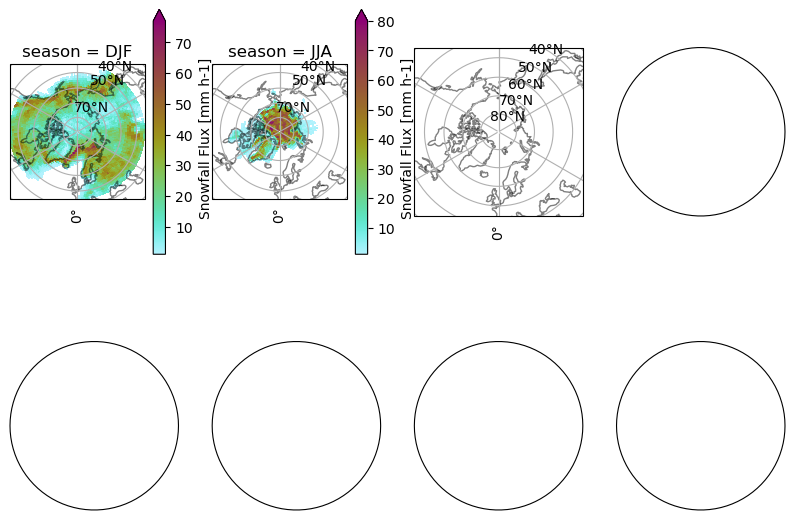

In [22]:
plt_seasonal_NH_SH(sf_count.where(sf_count>0.), levels=np.arange(0,230,10), cbar_label='{} frequency (month)'.format(sf_count.where(sf_count>0.).attrs['long_name'],), plt_title='ERA5 {} ({} - {})'.format(sf_count.where(sf_count>0.).attrs['long_name'], starty,endy))

sf_iwp = ((sf/(iwp)).groupby('time.season').mean('time', keep_attrs=True, skipna=True))
plt_seasonal_NH_SH(sf_iwp,np.arange(0, 0.01, 0.0025/4),cbar_label='precipitation efficency ()',plt_title='ERA5 Snowfall/IWP ({} - {})'.format(starty,endy))

sf_iwp_lwp = ((sf/(lwp+iwp)).groupby('time.season').mean('time', keep_attrs=True, skipna=True))
plt_seasonal_NH_SH(sf_iwp_lwp, np.arange(0, 0.01, 0.0025/4),cbar_label='precipiation efficency ()', plt_title='ERA Snowfall/(IWP + LWP) ({} {})'.format(starty,endy))

lwp_season = lwp.groupby('time.season').mean(dim='time',keep_attrs=True, skipna=True)
plt_seasonal_NH_SH(lwp_season, np.arange(0, 1220, 50),cbar_label='{} ({})'.format(lwp_season.attrs['long_name'], lwp_season.attrs['units']),plt_title='ERA5 {} ({} - {})'.format(lwp_season.attrs['long_name'], starty,endy))


In [23]:
dset_dict['IPSL-CM6A-LR']

<xarray.Dataset>
Dimensions:      (lat: 143, lon: 144, time: 1461, axis_nbounds: 2,
                  presnivs: 79, klevp1: 80, bnds: 2)
Coordinates:
  * lat          (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon          (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * time         (time) object 2006-01-01 12:00:00 ... 2009-12-31 12:00:00
  * presnivs     (presnivs) float32 1.012e+05 1.009e+05 ... 5.297 1.483
  * klevp1       (klevp1) float64 1.0 2.0 3.0 4.0 5.0 ... 77.0 78.0 79.0 80.0
  * bnds         (bnds) float32 1.0 2.0
    height       float64 ...
Dimensions without coordinates: axis_nbounds
Data variables:
    time_bounds  (time, axis_nbounds) object dask.array<chunksize=(1461, 2), meta=np.ndarray>
    clivi        (time, lat, lon) float32 dask.array<chunksize=(1461, 143, 144), meta=np.ndarray>
    clw          (time, presnivs, lat, lon) float32 dask.array<chunksize=(1461, 79, 143, 144), meta=np.ndarray>
    ps           (time, lat, lon) float32 dask.array<chunksize=(1461, 143, 144), meta=np.ndarray>
    ap           (klevp1) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    b            (klevp1) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    b_bnds       (bnds, klevp1) float64 dask.array<chunksize=(2, 80), meta=np.ndarray>
    ap_bnds      (bnds, klevp1) float64 dask.array<chunksize=(2, 80), meta=np.ndarray>
    prsn         (time, lat, lon) float32 dask.array<chunksize=(1461, 143, 144), meta=np.ndarray>
    tas          (time, lat, lon) float32 dask.array<chunksize=(1461, 143, 144), meta=np.ndarray>
Attributes: (12/51)
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-07-11T07:27:15Z
    tracking_id:            hdl:21.14100/d0f39596-6cc9-4d79-bf57-3ed7d0b20d87
    description:            CMIP6 historical
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    activity_id:            CMIP
    ...                     ...
    name:                   /ccc/work/cont003/gencmip6/p86caub/IGCM_OUT/IPSLC...
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.IPSL.IPSL-CM...
    variant_label:          r1i1p1f1
    realization_index:      1
    history:                Sat Dec  1 12:17:51 2018: ncatted -O -a realizati...
    NCO:                    "4.6.0"

<xarray.DataArray 'clw' (time: 1461, presnivs: 79, lat: 143, lon: 144)>
dask.array<mul, shape=(1461, 79, 143, 144), dtype=float32, chunksize=(1461, 79, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
  * lon       (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * time      (time) object 2006-01-01 12:00:00 ... 2009-12-31 12:00:00
  * presnivs  (presnivs) float32 1.012e+05 1.009e+05 1.007e+05 ... 5.297 1.483
    height    float64 ...
Attributes:
    long_name:           Mass Fraction of Cloud Liquid Water
    units:               g kg-1
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 d
    standard_name:       mass_fraction_of_cloud_liquid_water_in_air
    description:         Calculated as the mass of  cloud liquid water in the...
    history:             14/10/2022 12:40:35Z altered by F. Hellmuth: Convert...
    cell_measures:       area: areacella
    comment:             Includes both large-scale and convective cloud. Calc...
    original_units:      kg/kg

In [51]:
dset_dict['IPSL-CM6A-LR']['presnivs'].assign_coords({'time':'value', 'presnivs':'nz', })

<xarray.DataArray 'presnivs' (presnivs: 79)>
array([1.012021e+05, 1.009424e+05, 1.006534e+05, 1.003319e+05, 9.997420e+04,
       9.957655e+04, 9.913467e+04, 9.864384e+04, 9.809898e+04, 9.749448e+04,
       9.682430e+04, 9.608191e+04, 9.526024e+04, 9.435173e+04, 9.334834e+04,
       9.224155e+04, 9.102246e+04, 8.968182e+04, 8.821020e+04, 8.659811e+04,
       8.483623e+04, 8.291569e+04, 8.082840e+04, 7.856748e+04, 7.612779e+04,
       7.350645e+04, 7.070354e+04, 6.772281e+04, 6.457239e+04, 6.126538e+04,
       5.782047e+04, 5.426217e+04, 5.062074e+04, 4.693169e+04, 4.323469e+04,
       3.957199e+04, 3.598637e+04, 3.251885e+04, 2.920636e+04, 2.607983e+04,
       2.316271e+04, 2.047042e+04, 1.801036e+04, 1.578271e+04, 1.378158e+04,
       1.199642e+04, 1.041344e+04, 9.016865e+03, 7.790020e+03, 6.716147e+03,
       5.778999e+03, 4.963233e+03, 4.254644e+03, 3.640276e+03, 3.108450e+03,
       2.648733e+03, 2.251867e+03, 1.909687e+03, 1.615018e+03, 1.361581e+03,
       1.143891e+03, 9.571722e+02, 7.972696e+02, 6.605754e+02, 5.439607e+02,
       4.447146e+02, 3.604912e+02, 2.892627e+02, 2.292787e+02, 1.790303e+02,
       1.372198e+02, 1.027344e+02, 7.462312e+01, 5.207758e+01, 3.441441e+01,
       2.105668e+01, 1.150741e+01, 5.296797e+00, 1.483435e+00], dtype=float32)
Coordinates:
  * presnivs  (presnivs) float32 1.012e+05 1.009e+05 1.007e+05 ... 5.297 1.483
    height    float64 ...
    time      <U5 'value'
Attributes:
    name:           presnivs
    standard_name:  Vertical levels
    units:          Pa

In [58]:
dset_dict['IPSL-CM6A-LR']['nz'] = dset_dict['IPSL-CM6A-LR']['presnivs'].expand_dims(dim={'time':dset_dict['IPSL-CM6A-LR']['time'].shape[0], 
                                                       'lat':dset_dict['IPSL-CM6A-LR']['lat'].shape[0],
                                                       'lon':dset_dict['IPSL-CM6A-LR']['lon'].shape[0]},)
# presnivs.shape

In [77]:
dset_dict['IPSL-CM6A-LR']['nz'] = dset_dict['IPSL-CM6A-LR']['nz'].transpose('time','presnivs', 'lat', 'lon', )
dset_dict['IPSL-CM6A-LR']['clw']= dset_dict['IPSL-CM6A-LR']['clw'].transpose('time','presnivs', 'lat', 'lon', )

In [80]:
from wrf import interplevel

interplevel(field3d=dset_dict['IPSL-CM6A-LR']['clw'], 
            vert=dset_dict['IPSL-CM6A-LR']['nz'], 
            desiredlev=new_levels, missing=np.nan, )

KeyboardInterrupt: 

## Open CMIP6 variables
... by using `intake` from [pangeo.io](https://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/intake.html), specifically `intake-esm`.

An example on [Loading an ESM collection](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html#loading-an-esm-collection) and [searching for datasets](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html#searching-for-datasets) can also be found on the [Pangeo / ESGF Cloud Data Working Group documentation](https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html).

In [ ]:
# cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
# col = intake.open_esm_datastore(cat_url)
# col

## Search corresponding data
Get the data required for the analysis. Define variables, models, experiment, and time resolution as defined in <a href="#data_wrangling">2. Data Wrangling</a>
. 

* use member_id = 'r1i1p1f1'.
* using intake-esm’s `search()` function:
  * `col.search(variable_id, source_id, experiment_id, table_id, member_id, institution_id, grid_label)`

In [ ]:
# ## Variables
# variable_id=[
#             'cli',
#             'clivi',
#             'clw',
#             # 'lwp',
#             # 'pr',
#             'prsn',
#             # 'ta', 
#             'tas'
#              ]

In [ ]:
# ## Models
# # list_models = [
# #     'NorESM2-MM',
# #     'TaiESM1',
# #     'EC-Earth3-AerChem',
# #     'GFDL-ESM4',
# #     'SAM0-UNICON',
# #     'CAMS-CSM1-0',
# #     'CMCC-CM2-HR4',
# #     'MPI-ESM1-2-HR',
# #     'BCC-CSM2-MR',
# #     'E3SM-1-1',
# #     'CMCC-CM2-SR5',
# #     'CMCC-ESM2',
# #     'FGOALS-f3-L',
# #     'E3SM-1-1-ECA',
# #     'CIESM',
# #     'GFDL-CM4',
# #     'MRI-ESM2-0']  

# list_models = ['MIROC6', 'CESM2', 'CanESM5', 'AWI-ESM-1-1-LR', 'MPI-ESM1-2-LR',
#        'UKESM1-0-LL', 'HadGEM3-GC31-LL', 'CNRM-CM6-1', 'CNRM-ESM2-1',
#        'IPSL-CM6A-LR', 'IPSL-CM5A2-INCA']


In [ ]:
# ## experiment
# experiment_id = ['historical']

# ## time resolution
# t_res = ['day', 'CFday']

In [ ]:
# ## search for variables, models, ...
# cat = col.search(variable_id=variable_id, source_id=list_models, experiment_id=experiment_id, table_id = t_res, member_id=['r1i1p1f1'])
# # cat.df
# ## show the CMIP6 models found in pandas Dataframe 
# cat.df['source_id'].unique()

## Create dictionary from the list of datasets we found
Load the found datasets into xarray dataset containers using intake-esm’s `to_dataset_dict()` function, which yields a Python dictionary.

> **_NOTE:_** This step may take several minutes so be patient!

In [ ]:
# dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True,})

In [ ]:
# dset_dict.keys()

In [ ]:
# # list all merged datasets and show coordinates
# for keys, ds in dset_dict.items():
#     print('{}: {}'.format(keys, list(ds.dims)))

## Calendar
Not all models in CMIP6 use the same calendar. Hence we double check the time axis. Later, when we regrid to the same horizontal resolution (<a href="#regrid_hz">Regrid CMIP6 data</a>) we will assign the same calendars for each model. 

In [ ]:
# # metadata of the historical run:
# _d2 = pd.Series(["calendar",
#                  "branch_time_in_parent", #"parent_activity_id", "parent_experiment_id",	"parent_mip_era",
#                  "parent_source_id",#"parent_sub_experiment_id", 
#                  "parent_time_units",# "parent_variant_label"
#                   ])
# _d2 = pd.DataFrame(_d2).rename(columns={0:'index'})
# for i in dset_dict.keys():
#     _data = []
#     _names =[]
#     _data.append(dset_dict[i].time.to_index().calendar)
#     for k, v in dset_dict[i].attrs.items():
        
#         if 'parent_time_units' in k or 'branch_time_in_parent' in k or 'parent_source_id' in k:
#             _data.append(v)
#             _names.append(k)
#     _d2 = pd.concat([_d2,   pd.Series(_data)], axis=1)

# _d2.dropna(how='all', axis=1, inplace=True)
# _d2 = _d2.set_index('index')
# _d2.columns = _d2.loc['parent_source_id']
# _d2.drop('parent_source_id').T

## Show attributes and individual identifier
NorESM2-MM is going to be the reference model for the horizontal grid. The `xarray` datasets inside `dset_dict` can be extracted as any value in a Python dictionary.

The dictonary key for NorESM2-MM is: **CMIP.NCC.NorESM2-MM.historical.Amon.gn**

In [ ]:
# if variable_id[0] == 'lwp':
#     ds = dset_dict['CMIP.NCC.NorESM2-MM.historical.AERmon.gn']
# else:
#     ds = dset_dict['CMIP.NCC.NorESM2-MM.historical.Amon.gn']
    

## attributes of the xarray dataset 
# ds[variable_id[0]].attrs, ds.attrs['tracking_id']

In [ ]:
# dset_dict.keys()

In [ ]:
# for model in dset_dict.keys():
#     for keys in dset_dict[model].keys():
#         print(model, keys)

## Assign attributes to the variables

We will assign the attributes to the variables as in ERA5 to make CMIP6 and ERA5 variables comperable.

* [`cli`](http://clipc-services.ceda.ac.uk/dreq/u/dd916e3e2eca18cda5d9f81749d0c91c.html) and [`clw`](http://clipc-services.ceda.ac.uk/dreq/u/86b2b3318a73839edfafa9d46864aadc.html) in **kg kg-1** $\rightarrow$ Multiply by **1000** to get **g kg-1**
* [`clivi`](http://clipc-services.ceda.ac.uk/dreq/u/73c496f5669cc122cf1cddfe4df2a27a.html) and [`lwp`](http://clipc-services.ceda.ac.uk/dreq/u/e6b31a1928879fcd3c92fe7b592f070e.html) in **kg m-2** $\rightarrow$ Multiply by **1000** to get **g m-2**
* [`pr`](http://clipc-services.ceda.ac.uk/dreq/u/62f26742cf240c1b5169a5cd511196b6.html) and [`prsn`](http://clipc-services.ceda.ac.uk/dreq/u/051919eddec810e292c883205c944ceb.html) in **kg m-2 s-1** $\rightarrow$ Multiply by **86400** to get **mm day-1**


In [ ]:
# for var_id in variable_id:
#     for keys in dset_dict.keys():
#         if var_id == 'cli' or var_id == 'clw' or var_id == 'lwp' or var_id  == 'clivi':
#             dset_dict[keys][var_id] = dset_dict[keys][var_id]*1000
#             if var_id == 'cli':
#                 dset_dict[keys][var_id].attrs = {'units': 'g kg-1', 'long_name': 'Mass Fraction of Cloud Ice', 'standard_name': 'mass_fraction_of_cloud_ice_in_air', 'comment': 'Includes both large-scale and convective cloud. This is calculated as the mass of cloud ice in the grid cell divided by the mass of air (including the water in all phases) in the grid cell. It includes precipitating hydrometeors ONLY if the precipitating hydrometeors affect the calculation of radiative transfer in model.', 'cell_methods': 'area: time: mean (interval: 5 minutes)', 'cell_measures': 'area: areacella',}
#             if var_id == 'clw':
#                 dset_dict[keys][var_id].attrs = {'units': 'g kg-1', 'long_name': 'Mass Fraction of Cloud Liquid Water', 'standard_name': 'mass_fraction_of_cloud_liquid_water_in_air', 'comment': 'Includes both large-scale and convective cloud. Calculate as the mass of cloud liquid water in the grid cell divided by the mass of air (including the water in all phases) in the grid cells. Precipitating hydrometeors are included ONLY if the precipitating hydrometeors affect the calculation of radiative transfer in model.', 'cell_methods': 'area: time: mean', 'cell_measures': 'area: areacella'}
#             if var_id == 'clivi':
#                 dset_dict[keys][var_id].attrs = {'units': 'g m-2', 'long_name': 'Ice Water Path', 'comment': 'mass of ice water in the column divided by the area of the column (not just the area of the cloudy portion of the column). Includes precipitating frozen hydrometeors ONLY if the precipitating hydrometeor affects the calculation of radiative transfer in model.', 'cell_methods': 'area: time: mean', 'cell_measures': 'area: areacella'} 
#             if var_id == 'lwp':
#                 dset_dict[keys][var_id].attrs = {'units': 'g m-2', 'long_name': 'Liquid Water Path', 'comment': 'The total mass of liquid water in cloud per unit area.', 'cell_methods': 'area: time: mean', 'cell_measures': 'area: areacella'}

#         if var_id == 'pr' or var_id == 'prsn':
#             try: 
#                 dset_dict[keys][var_id] = dset_dict[keys][var_id]*86400
#                 if var_id == 'pr':
#                     dset_dict[keys][var_id].attrs = {'units': 'mm day-1', 'long_name': 'Precipitation', 'comment': 'includes both liquid and solid phases','cell_methods': 'area: time: mean', 'cell_measures': 'area: areacella'}
#                 if var_id == 'prsn':
#                     dset_dict[keys][var_id].attrs = {'units': 'mm day-1', 'long_name': 'Snowfall', 'comment': 'At surface; includes precipitation of all forms of water in the solid phase', 'cell_methods': 'area: time: mean', 'cell_measures': 'area: areacella'}
#             except KeyError:
#                 continue
        

 ## Interpolate from CMIP6 hybrid sigma-pressure levels to ERA5 isobaric pressure levels

The vertical variables in the CMIP6 models are in hybrid sigma-pressure levels. Hence the vertical variable in the xarray datasets in `dset_dict` will be calculated by using the [GeoCAT-comb](https://geocat-comp.readthedocs.io/en/latest/index.html#) function to [interpolate data from hybrid-sigma levels to isobaric levels](https://geocat-comp.readthedocs.io/en/latest/user_api/generated/geocat.comp.interpolation.interp_hybrid_to_pressure.html#geocat.comp.interpolation.interp_hybrid_to_pressure).

The GeoCAT-comb function takes the following input:
* `data`:   Multidimensional data array, which holds hybrid-sigma levels and has a lev_dim coordinate.
* `ps`:     A multi-dimensional array of surface pressures (Pa), same time/space shape as data. Not all variables include the surface pressure, hence we will search the `Pangeo.io` catalog to find the surface pressure associated with the model. 
* `hyam`:     One-dimensional arrays containing the hybrid A coefficients. Must have the same dimension size as the lev_dim dimension of data.
* `hybm`:     One-dimensional arrays containing the hybrid B coefficients. Must have the same dimension size as the lev_dim dimension of data.
* `p0`:       Scalar numeric value equal to surface reference pressure (Pa). Defaults to 100000 Pa.
* `new_levels`: A one-dimensional array of output pressure levels (Pa). We will use the pressure of `air_temperature` (19 levels).


$$ P(i,j,k) = hyam(k) p0 + hybm(k) ps(i,j)$$

```
import geocat

geocat.comp.interpolation.interp_hybrid_to_pressure(data      =ds['variable'], 
                                                    ps        =ds['ps'], 
                                                    hyam      =ds['a'], 
                                                    hybm      =ds['b'], 
                                                    p0        =ds['p0'], 
                                                    new_levels=ds['plev'])
```


In [ ]:
# # load the levels from the ERA5 file and transfer to Pa
# era_level = (xr.open_dataset('/scratch/franzihe/input/ERA5/monthly_means/0.25deg/clwc_Amon_ERA5_198501_198912.nc')['level'])*100

# if (('clw' or 'cli' or 'ta') in variable_id) == True:
#     # if var_id == 'clw' or var_id == 'cli':
#     for keys in dset_dict.keys():
#         # rename cmip pressure level for atmospheric temperature
#         dset_dict[keys] = dset_dict[keys].rename({'plev':'clev'})
#         # interpolate from hybrid to pressure levels for clw and cli
#         for var_id in [variable_id[variable_id.index('clw')], variable_id[variable_id.index('cli')]]:

#             if ('ps' in list(dset_dict[keys].keys())) == False:     # valid for models which don't provide ps in the clw or cli dataset
#                 model = keys.split('.')[2]
#                 ds_ps = col.search(source_id=model, table_id = ['Amon', ], experiment_id=['historical'], variable_id=['ps','p0', ], member_id=['r1i1p1f1']).to_dataset_dict(zarr_kwargs={'use_cftime':True,}, )
#                 dset_dict[keys].update(ds_ps[keys], )
#                 dset_dict[keys]['ps'] = dset_dict[keys]['ps'].isel(member_id = 0)
                
                
#             # Rename datasets with different naming convention for constant A
#             if ('a' in list(dset_dict[keys].keys())) == False:
#                 dset_dict[keys] = dset_dict[keys].rename({'ap':'a', 'ap_bnds': 'a_bnds'})
                    
                    
#             # Convert the model level to isobaric levels
#             #### a, b, ps, p0
#             if ('a' in list(dset_dict[keys].keys())) == True and ('b' in list(dset_dict[keys].keys())) == True and ('p0' in list(dset_dict[keys].keys())) == True and ('ps' in list(dset_dict[keys].keys())) == True:
#                 dset_dict[keys]['{}_interp'.format(var_id)] = gc.interpolation.interp_hybrid_to_pressure(data=dset_dict[keys][var_id].isel(member_id = 0), 
#                                                                                                                 ps=dset_dict[keys]['ps'],hyam=dset_dict[keys]['a'],
#                                                                                                                 hybm=dset_dict[keys]['b'],
#                                                                                                                 p0=dset_dict[keys]['p0'].values, 
#                                                                                                                 new_levels=(era_level).values, )
#                 # # remove the variables needed for the calculation of the isobaric levels. If this step is not performed, 
#                 # # the horizontal regridding will not be possible.
#                 # dset_dict[keys] = dset_dict[keys].drop(('a', 'p0', 'b', 'ps', 'a_bnds', 'b_bnds', var_id))
#                 dset_dict[keys] = dset_dict[keys].drop((var_id))
#                 dset_dict[keys] = dset_dict[keys].rename({'{}_interp'.format(var_id):var_id})

#             #### a, b, ps
#             elif ('a' in list(dset_dict[keys].keys())) == True and ('b' in list(dset_dict[keys].keys())) == True and ('ps' in list(dset_dict[keys].keys())) == True and ('p0' in list(dset_dict[keys].keys())) == False:
#                 dset_dict[keys]['{}_interp'.format(var_id)] = gc.interpolation.interp_hybrid_to_pressure(data=dset_dict[keys][var_id].isel(member_id=0), 
#                                                                                                                 ps=dset_dict[keys]['ps'],
#                                                                                                                 hyam=dset_dict[keys]['a'], 
#                                                                                                                 hybm=dset_dict[keys]['b'],
#                                                                                                                 p0=100000.0,
#                                                                                                                 new_levels=(era_level).values, )
#                 # dset_dict[keys] = dset_dict[keys].drop(('a', 'b', 'ps', 'a_bnds', 'b_bnds', var_id))
#                 dset_dict[keys] = dset_dict[keys].drop((var_id))
#                 dset_dict[keys] = dset_dict[keys].rename({'{}_interp'.format(var_id):var_id})
        
#         # remove the variables needed for the calculation of the isobaric levels. If this step is not performed, 
#         # the horizontal regridding will not be possible.
#         if ('p0' in list(dset_dict[keys].keys())) == True:
#             dset_dict[keys] = dset_dict[keys].drop(('a', 'p0', 'b', 'ps', 'a_bnds', 'b_bnds',))
#         elif ('p0' in list(dset_dict[keys].keys())) == False:
#             dset_dict[keys] = dset_dict[keys].drop(('a', 'b', 'ps', 'a_bnds', 'b_bnds',))
 

## Regrid CMIP6 data to NorESM2-MM grid <a id='regrid_hz'></a>

We want to conduct statistical analysis at the annual and seasonal timescales to determine the biases in cloud phase and precipitation (liquid and solid) in the CMIP6 models. At the moment we have all historical data from the CMIP6 models. For this, we will have to extract the 30-year period between 1985 and 2014.

$\rightarrow$ Define a start and end year.

The CMIP6 high resolution models have approximately a nominal resolution of 100km. But not all have identical grid spacing. Hence we will make use of the python package `xesmf` and the documentation on [decreasing resolution](https://xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html#Decreasing-resolution), [Limitations and warnings](https://xesmf.readthedocs.io/en/latest/notebooks/Masking.html?highlight=conservative#Limitations-and-warnings). 

NorESM2-MM will be the reference grid since we want to compare the models to the ERA5 data. The ERA5 data has a nominal resolution of 0.25deg and has been regridded to the same horizontal resolution as the NorESM2-MM in [the ERA5 Jupyter Notebook](../ERA5/ERA5_1985-2014.ipynb). 

$\rightarrow$ Define NorESM2-MM as the reference grid `ds_out`.

Create a new Python dictionary (`ds_gridded_dict`) with the regridded CMIP6 `xarray` datasets between 1985 an 2014. Save each regridded model to a `netcdf`, locally. 

> **_NOTE:_** This step may take several minutes!

In [ ]:
starty = 1985; endy = 2014
year_range = range(starty, endy+1)

In [ ]:
# ds_out = dset_dict['CMIP.NCC.NorESM2-MM.historical.Amon.gn']
# ds_in  = dset_dict[model]

# import xesmf

# # Regridder data
# regridder = xesmf.Regridder(ds_in, ds_out, "conservative")

# # Apply regridder to data
#  # the entire dataset can be processed at once
# ds_in_regrid = regridder(ds_in)

In [ ]:
# # create dictionary for reggridded data
# ds_gridded_dict = dict()

# # Read in the output grid from NorESM
# if variable_id[0] == 'lwp':
#     ds_out = dset_dict['CMIP.NCC.NorESM2-MM.historical.AERmon.gn'].isel(member_id = 0)
# else:
#     ds_out = dset_dict['CMIP.NCC.NorESM2-MM.historical.Amon.gn'].isel(member_id = 0)
# ds_out = ds_out.sel(time = ds_out.time.dt.year.isin(year_range)).squeeze()


# counter = 0

# for keys in dset_dict.keys():
#     # select only models which have atmospheric monthly values
#     amon = keys.split('.')[-2]
#     if amon == 'Amon' or amon == 'AERmon': 
#         # select model name 
#         model = keys.split('.')[2]
        
#         # select where data should be saved
#         if len(variable_id) > 1:
#             filename = '{}_Amon_1deg_{}01_{}12.nc'.format(variable_id, starty, endy)
#         elif len([variable_id]) == 1:
#             filename = '{}_Amon_1deg_{}01_{}12.nc'.format(variable_id[0], starty, endy)
#         # filename = '{}_Amon_1deg_{}01_{}12.nc'.format(variable_id[0], starty, endy)
#         savepath = '/scratch/franzihe/output/CMIP6_hist/1deg/{}/'.format(model)
#         nc_out = savepath + filename
#         files = glob(nc_out)
        
#         # Input data from CMIP6 model to be regridded
#         ds_in = dset_dict[keys].isel(member_id = 0)
#         ds_in = ds_in.sel(time = ds_in.time.dt.year.isin(year_range)).squeeze()
            
#         # common time grid
#         ds_in['time'] = ds_out['time']
            

#         # Regrid data
#         ds_in_regrid = fct.regrid_data(ds_in, ds_out)


#         # Shift the longitude from 0-->360 to -180-->180 and sort by longitude and time
#         ds_in_regrid = ds_in_regrid.assign_coords(lon=(((ds_in_regrid.lon + 180) % 360) - 180)).sortby('lon').sortby('time')
#         ds_in_regrid = ds_in_regrid.reset_coords(names=['time_bnds', ], drop=True)
            
            
#         # create dataset with all models
#         ds_gridded_dict[model] = ds_in_regrid

#         # if nc_out in files:
#         #     print('{} is downloaded'.format(nc_out))
#         #     counter += 1
#         #     print('Have regridded in total: {:} files'.format(str(counter)))
#         # else:    
#             # Save to netcdf file
#         ds_in_regrid.to_netcdf(nc_out)
#         print('file written: {}'.format(nc_out))

## Connect all models into one Dataset with new coordinate 'model'

We will create a `xarray.Dataset` with all CMIP6 models, after the interpolation to the same horizonal (and vertical) resolution. This step will make the next steps easier, as we will not need the the full dictonary key and can just use the model name.

In [ ]:
# # not needed if regridding works
# ds_gridded_dict = dict()
# for model in list_models:
#     ds_gridded_dict[model] = xr.open_dataset('/scratch/franzihe/output/CMIP6_hist/1deg/{}/{}_Amon_1deg_198501_201412.nc'.format(model,variable_id))


In [ ]:
# # expand the model with nan array where missing variables
# for model in ds_gridded_dict.keys():
#     for var in variable_id:
#         # print(var, model)
#         if (var in ds_gridded_dict[model].variables) == False:
#             print(model, var)
#             if var == 'pr' or var == 'prsn':
#                 ds_gridded_dict[model][var] = xr.DataArray(data=da.full(shape = (ds_gridded_dict[model]['time'].shape[0], 
#                                                                                  ds_gridded_dict[model]['lat'].shape[0], 
#                                                                                  ds_gridded_dict[model]['lon'].shape[0]), 
#                                                             fill_value=np.nan, 
#                                                             chunks=(120, 721, 1440/2)), dims = [ds_gridded_dict[model].time.dims[0], ds_gridded_dict[model].lat.dims[0], ds_gridded_dict[model].lon.dims[0]], coords=[ds_gridded_dict[model].time.values, ds_gridded_dict[model].lat.values, ds_gridded_dict[model].lon.values])

In [ ]:
# _ds = list(ds_gridded_dict.values())
# _coord = list(ds_gridded_dict.keys())
# ds_cmip = xr.concat(objs=_ds, dim=_coord, coords="all").rename({'concat_dim':'model'})
# ds_cmip = ds_cmip.drop('bnds')

In [ ]:
ds_cmip = xr.open_mfdataset('/scratch/franzihe/output/CMIP6_hist/1deg/*.nc')
ds_cmip

## Supercooled liquid water fraction

$$SLF = \frac{\text{cloud liquid water content}}{\text{cloud liquid water content} + \text{cloud ice water content}}$$

In [ ]:
# ds_cmip['SLF'] = ds_cmip['clw']/(ds_cmip['cli'] + ds_cmip['clw'])
# ds_cmip['SLF'].attrs = {'units': '', 'long_name':'Super cooled liquid water fraction'}

In [ ]:
# # ds_cmip['SLF'] = fct.set4D_latitude_values_nan(ds_cmip['SLF'], 45, -45)

# # find only SLF where snowfall
# ds_cmip['SLF_sf'] = ds_cmip['SLF'].where((ds_cmip['prsn'] * 3600/86400) >= 0.01)
# ds_cmip['SLF_sf'] = ds_cmip['SLF_sf'].sortby('latitude', ascending=True)
# ds_cmip['SLF_sf'] = ds_cmip['SLF_sf'].groupby('time.season').mean(('time', 'longitude'), skipna=True)

# fig, axsm = plt.subplots(2,2, sharex=True, sharey=True, figsize=[15, 7.5])
# for ax, sea in zip(axsm.flatten(), ds_cmip['SLF_sf'].season):
#     cf = ds_cmip['SLF_sf'].sel(season=sea).plot(ax=ax,x='latitude', y='level', cmap=cm.tokyo_r, levels=np.arange(0,1.1,0.1), ylim= [1000, 1], yincrease=False, add_colorbar=False)
#     ax.grid()
#     ax.set(title='season = {}'.format(sea.values), ylabel='Pressure [hPa]', xlabel='Latitude')
    

# fig.suptitle('ERA5 ({} - {})'.format(starty, endy), fontweight="bold")
# cbaxes = fig.add_axes([0.1, 0.0, 0.8, 0.025])
# cbar = plt.colorbar(cf, cax=cbaxes, shrink=0.5, orientation='horizontal', label='Supercooled liquid water fraction')


## Statistics
For variables:
- Snowfall [sf]
- Total column cloud liquid, supercooled liqid, and rain water [tclslrw]
- Total column cloud ice, snow water [tcisw]
- 2m-Temperature [2t]

1. Find where liquid water path is $\ge$ 5 g m-2 
2. Find where snowfall is $\ge$ 0.01mm h-1
3. Find where 2m-temperature $\le$ 0 $^o$ C 

In [ ]:
def set4D_latitude_values_nan(array, upper_lat, lower_lat):
    array[:,:,int(array['lat'].where((array['lat'] > lower_lat) & (array['lat'] < upper_lat)).argmin('lat')) : int(array['lat'].where((array['lat'] > lower_lat) & (array['lat'] < upper_lat)).argmax('lat')), :] = xr.DataArray(data=da.full(shape=(array[:,:,int(array['lat'].where((array['lat']>lower_lat) & (array['lat']<upper_lat)).argmin('lat')) :\
                                           int(array['lat'].where((array['lat']>lower_lat) & (array['lat']<upper_lat)).argmax('lat')), :]).shape,
                          fill_value=np.nan),
             dims=(array[:,:,int(array['lat'].where((array['lat']>lower_lat) & (array['lat']<upper_lat)).argmin('lat')) :\
                             int(array['lat'].where((array['lat']>lower_lat) & (array['lat']<upper_lat)).argmax('lat')), :]).dims,
             coords=(array[:,:,int(array['lat'].where((array['lat']>lower_lat) & (array['lat']<upper_lat)).argmin('lat')) :\
                               int(array['lat'].where((array['lat']>lower_lat) & (array['lat']<upper_lat)).argmax('lat')), :]).coords)

    return array

In [ ]:
ds_cmip['prsn']  = set4D_latitude_values_nan(ds_cmip['prsn'], 45, -45)
ds_cmip['lwp']   = set4D_latitude_values_nan(ds_cmip['lwp'], 45, -45)
ds_cmip['clivi'] = set4D_latitude_values_nan(ds_cmip['clivi'], 45, -45)
ds_cmip['tas']   = set4D_latitude_values_nan(ds_cmip['tas'], 45, -45)

In [ ]:
# 1. find where LWP >=5 gm-2
sf = ds_cmip['prsn'].where(ds_cmip['lwp']>=5)
lwp = ds_cmip['lwp'].where(ds_cmip['lwp']>=5)
iwp = ds_cmip['clivi'].where(ds_cmip['lwp']>=5)
t2 = ds_cmip['tas'].where(ds_cmip['tas']>=5)

# 2. find where snowfall >= 0.01mmh-1
unit_sf = ds_cmip['prsn']*(3600/86400)
sf = sf.where(unit_sf>0.01)
lwp = lwp.where(unit_sf>0.01)
iwp = iwp.where(unit_sf>0.01)
t2 = t2.where(unit_sf>0.01)

# 3. find where 2m-temperature <= 0C
sf = sf.where(ds_cmip['tas']<=273.15)
lwp = lwp.where(ds_cmip['tas']<=273.15)
iwp = iwp.where(ds_cmip['tas']<=273.15)
t2 = t2.where(ds_cmip['tas']<=273.15)

# count occurences per season
sf_count = sf.groupby('time.season').count(dim='time',keep_attrs=True)
lwp_count = lwp.groupby('time.season').count(dim='time',keep_attrs=True)
iwp_count = iwp.groupby('time.season').count(dim='time',keep_attrs=True)
t2_count = t2.groupby('time.season').count(dim='time',keep_attrs=True)


In [ ]:
ds_cmip['lwp'].where(ds_cmip['lwp']>=5)

In [ ]:
def plt_seasonal_NH_SH(variable,levels,cbar_label,plt_title):

    f, axsm = plt.subplots(nrows=2,ncols=4,figsize =[10,7], subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=0.0,globe=None)})

    for ax, season in zip(axsm.flatten()[:4], variable.season):
        ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
        ax.set_extent([-180, 180, 90, 45], ccrs.PlateCarree())
        ax.set(title ='season = {}'.format(season.values))
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels   = False
        gl.right_labels = False
        variable.sel(season=season).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False,
                            cmap=cm.hawaii_r, levels=levels)

    for ax, i, season in zip(axsm.flatten()[4:], np.arange(5,9), variable.season):
        ax.remove()
        ax = f.add_subplot(2,4,i, projection=ccrs.SouthPolarStereo(central_longitude=0.0, globe=None))
        ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
        ax.set_extent([-180, 180, -90, -45], ccrs.PlateCarree())
        ax.set(title ='season = {}'.format(season.values))
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels   = False
        gl.right_labels = False
        cf = variable.sel(season=season).plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False,
                            cmap=cm.hawaii_r, levels=levels)

    cbaxes = f.add_axes([1.0125, 0.025, 0.025, 0.9])
    cbar = plt.colorbar(cf, cax=cbaxes, shrink=0.5,extend='max', orientation='vertical', label=cbar_label)
    f.suptitle(plt_title, fontweight="bold");
    plt.tight_layout(pad=0., w_pad=0., h_pad=0.)

In [ ]:
for model in sf_count['model']:

    # snowfall event occurance
    plt_seasonal_NH_SH((sf_count.where(sf_count>0.)).sel(model=model),np.arange(0,100,10),cbar_label ='{} frequency (month)',plt_title='{} {} ({} - {}) Count of months where sf >= 7.2mm'.format(model.values,sf_count.where(sf_count>0.).attrs['long_name'], starty,endy))

    # snowfall divided by ice water path
    sf_iwp = ((sf/(iwp)).groupby('time.season').mean('time', keep_attrs=True, skipna=True))
    plt_seasonal_NH_SH(sf_iwp.sel(model=model),np.arange(0,0.0475,0.0025),cbar_label='precipitation efficency ()',plt_title='{} Snowfall/IWP ({} - {}) where sf >= 7.2mm'.format(model.values,starty,endy))

    # snowfall divided by the sum of ice and liquid water path
    sf_iwp_lwp = ((sf/(lwp+iwp)).groupby('time.season').mean('time', keep_attrs=True, skipna=True))
    plt_seasonal_NH_SH(sf_iwp_lwp.sel(model=model), np.arange(0,0.0475,0.0025),cbar_label='precipiation efficency ()', plt_title='{} Snowfall/(IWP + LWP) ({} {}) where sf >= 7.2mm'.format(model.values,starty,endy))

    # liquid water path
    lwp_season = lwp.groupby('time.season').mean(dim='time',keep_attrs=True, skipna=True)
    plt_seasonal_NH_SH(lwp_season.sel(model=model), np.arange(0,360, 10),cbar_label='{} ({})'.format(lwp_season.attrs['long_name'], lwp_season.attrs['units']),plt_title='{} {} ({} - {}) Count of months where sf >= 7.2mm'.format(model.values,lwp_season.attrs['long_name'], starty,endy))


In [ ]:
_iwp = iwp.groupby('time.season').mean(('time', ), keep_attrs=True, skipna=True)
_lwp = lwp.groupby('time.season').mean(('time', ), keep_attrs=True, skipna=True)
_sf = sf.groupby('time.season').mean(('time', ), keep_attrs=True, skipna=True)

In [ ]:

'EC-Earth3-AerChem'
'NorESM2-MM'
'GFDL-ESM4'
'TaiESM1'

In [ ]:
_iwp.min().values, _iwp.max().values

In [ ]:
_sf.min().values, _sf.max().values

In [ ]:
from matplotlib.colors import LogNorm

In [ ]:
def plt_2dhist_iwp_sf(_iwp, _sf,model ):
    f, axsm = plt.subplots(nrows=2,ncols=4,figsize =[10,5], sharex=True, sharey=True)
    cmap = cm.batlow
    # levels = np.arange(0.1,65000,5000)
    # norm = BoundaryNorm(levels, ncolors=cmap.N, )
    norm = LogNorm(vmin=1, vmax=65000)



    for ax, season in zip(axsm.flatten()[:4], _iwp.season):
        Z, xedges, yedges = np.histogram2d((_iwp.where(_iwp['lat'] >=45).sel(season=season).values.flatten()), 
                                        (_sf.where(_sf['lat'] >=45).sel(season=season).values.flatten()), 
                                        bins=[54, 25], 
                                        range=[[5,545],[0, 25]])   

        im = ax.pcolormesh(xedges, yedges, Z.transpose(), cmap=cmap,norm=norm,)
        # cbar = f.colorbar(im, ax=ax,)
        ax.set(title =r'lat$\geq 45^\circ$N; season = {}'.format(season.values))
        ax.grid()

    for ax, season in zip(axsm.flatten()[4:], _iwp.season):
        Z, xedges, yedges = np.histogram2d((_iwp.where(_iwp['lat'] <=-45).sel(season=season).values.flatten()), 
                                        (_sf.where(_sf['lat'] <=-45).sel(season=season).values.flatten()), 
                                        bins=[54, 25], 
                                        range=[[5,545],[0, 25]])   

        im = ax.pcolormesh(xedges, yedges, Z.transpose(), cmap=cmap,norm=norm,)
        # cbar = f.colorbar(im, ax=ax, )
        ax.set(title =r'lat$\leq-45^\circ$S; season = {}'.format(season.values))
        
        ax.set_xlabel('Ice Water Path ({})'.format(_iwp.attrs['units']))
        ax.grid()
        
    axsm.flatten()[0].set_ylabel('{} ({})'.format(_sf.attrs['long_name'], _sf.attrs['units']))
    axsm.flatten()[4].set_ylabel('{} ({})'.format(_sf.attrs['long_name'], _sf.attrs['units']))


    cbaxes = f.add_axes([1.0125, 0.025, 0.025, 0.9])
    cbar = plt.colorbar(im, cax=cbaxes, shrink=0.5, orientation='vertical', label='frequency')
    f.suptitle('{} ({} - {}) Months where sf >= 7.2mm'.format(model, starty,endy), fontweight="bold");
    plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)


In [ ]:
model = ['EC-Earth3-AerChem', 'NorESM2-MM', 'GFDL-ESM4', 'TaiESM1']
for model in model:
    plt_2dhist_iwp_sf(_iwp.sel(model=model), _sf.sel(model='NorESM2-MM'), model)

## Find mixed-phase clouds
Calculate the IWC/LWC statistics given by the values. Setting the value to 0.5 will find the level in the atmosphere where IWC and LWC are 50/50. Setting it to a value of 0.7 will find the level where IWC is 70% while LWC is 30%.

1. find the fraction of IWC to LWC 
$$fraction = \frac{IWC}{IWC + LWC}$$
2. find the nearest value to given IWC-fraction
3. find atmospheric pressure levels where IWC/LWC fraction occurs
4. find the index of the first atmospheric pressure level
5. use the index to select variables


## Create dictionary from the list of datasets we want to use for the IWC/LWC statistics
Calculate the IWC/LWC statistics given by the values. Setting the value to 0.5 will find the level in the atmosphere where IWC and LWC are 50/50. Setting it to a value of 0.7 will find the level where IWC is 70% while LWC is 30%.

In [ ]:
_ds = list(dset_dict2.values())
_coord = list(dset_dict2.keys())
ds_cmip_1deg = xr.concat(objs=_ds, dim=_coord, coords="all").rename({'concat_dim':'stat'})

# 3. Exploratory Data Analysis <a id='exploratory'></a>





## Create seasonal mean of all regridded models
...and plot seasonal mean of each individual model

In [ ]:
for var_id in list(ds_cmip.keys()):
    ds_cmip = fct.seasonal_mean_std(ds_cmip, var_id)

In [ ]:
# extract the variable name similar to ERA5 for plotting
var = fct.to_era_variable[variable_id[variable_id.index('prsn')]]

for model in ds_cmip.model.values:
    fct.plt_spatial_seasonal_mean(ds_cmip[variable_id[variable_id.index('prsn')]+'_season_mean'].sel(model=model), var, title='{} MEAN ({} - {})'.format(model,starty, endy))

## Create model mean/spread of seasonal mean of all regridded models

In [ ]:
ds_cmip[variable_id[variable_id.index('prsn')]+'_season_model_mean'] = ds_cmip[variable_id[variable_id.index('prsn')]+'_season_mean'].mean('model', keep_attrs=True, skipna = True)
ds_cmip[variable_id[variable_id.index('prsn')]+'_season_model_std']  = ds_cmip[variable_id[variable_id.index('prsn')]+'_season_mean'].std('model', keep_attrs=True, skipna = True)

In [ ]:
fig, axs, im = fct.plt_spatial_seasonal_mean(ds_cmip[variable_id[variable_id.index('prsn')]+'_season_model_mean'], var, add_colorbar=False, title='CMIP6 - high resolution (1985 - 2014)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
cb.set_label(label='MEAN - {}'.format(fct.plt_dict[var][fct.plt_dict['header'].index('label')]), weight='bold')

plt.tight_layout()


axs[2].text(1,-0.12, ds_cmip.model.values.tolist()[0:5], size=12, ha="center", 
         transform=axs[2].transAxes, bbox ={'facecolor':'green',
                'alpha':0.6,
                'pad':5})
if len(ds_cmip.model.values.tolist()) > 4:
    axs[2].text(1,-0.25, ds_cmip.model.values.tolist()[5:10], size=12, ha="center", 
            transform=axs[2].transAxes, bbox ={'facecolor':'green',
                    'alpha':0.6,
                    'pad':5})
if len(ds_cmip.model.values.tolist()) > 10:
    axs[2].text(1,-0.38, ds_cmip.model.values.tolist()[10:-1], size=12, ha="center", 
            transform=axs[2].transAxes, bbox ={'facecolor':'green',
                    'alpha':0.6,
                    'pad':5})
    

# save figure to png
figdir = '/uio/kant/geo-metos-u1/franzihe/Documents/Figures/CMIP6/'
figname = '{}_season_mean_1deg_{}_{}.png'.format(variable_id[0], starty, endy)
plt.savefig(figdir + figname, format = 'png', bbox_inches = 'tight', transparent = False)

In [ ]:
fig, axs, im = fct.plt_spatial_seasonal_mean(ds_cmip[variable_id[variable_id.index('prsn')]+'_season_model_mean'], var, add_colorbar=False, title='CMIP6 - high resolution (1985 - 2014)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
cb.set_label(label='MEAN - {}'.format(fct.plt_dict[var][fct.plt_dict['header'].index('label')]), weight='bold')



for ax, i in zip(axs, ds_cmip[variable_id[variable_id.index('prsn')]+'_season_model_std'].season):
    sm = ds_cmip[variable_id[variable_id.index('prsn')]+'_season_model_std'].sel(season=i).plot.contour(ax=ax, transform=ccrs.PlateCarree(), 
                                                                      robust=True,
                                                                      vmin = fct.plt_dict[var][fct.plt_dict['header'].index('vmin_std')], 
                                                                      vmax = fct.plt_dict[var][fct.plt_dict['header'].index('vmax_std')],
                                                                       levels = 6,
                                                                      cmap=cm.lajolla,
                                                                      add_colorbar=False)
    
cbar_ax = fig.add_axes([1.10, 0.15, 0.025, 0.7])
sb = fig.colorbar(sm, cax=cbar_ax, orientation="vertical", fraction=0.046, pad=0.04)
sb.set_label(label='STD - {}'.format(fct.plt_dict[var][fct.plt_dict['header'].index('label')]), weight='bold')


plt.tight_layout()


axs[2].text(1,-0.12, ds_cmip.model.values.tolist()[0:5], size=12, ha="center", 
         transform=axs[2].transAxes, bbox ={'facecolor':'green',
                'alpha':0.6,
                'pad':5})
if len(ds_cmip.model.values.tolist()) > 4:
    axs[2].text(1,-0.25, ds_cmip.model.values.tolist()[5:10], size=12, ha="center", 
            transform=axs[2].transAxes, bbox ={'facecolor':'green',
                    'alpha':0.6,
                    'pad':5})
if len(ds_cmip.model.values.tolist()) > 10:
    axs[2].text(1,-0.38, ds_cmip.model.values.tolist()[10:-1], size=12, ha="center", 
            transform=axs[2].transAxes, bbox ={'facecolor':'green',
                    'alpha':0.6,
                    'pad':5})
# save figure to png
figdir = '/uio/kant/geo-metos-u1/franzihe/Documents/Figures/CMIP6/'
figname = '{}_season_mean_std_1deg_{}_{}.png'.format(variable_id[0], starty, endy)
plt.savefig(figdir + figname, format = 'png', bbox_inches = 'tight', transparent = False)

In [ ]:
# save to netcdf
filename = '{}_1deg_{}01_{}12.nc'.format(variable_id[0], starty, endy)
savepath = '/scratch/franzihe/output/CMIP6_hist/1deg/'
nc_out = savepath + filename
files = glob(nc_out)

counter = 0 
# Save to netcdf file
if nc_out in files:
#     print('{} is downloaded'.format(nc_out))
#     counter += 1
#     print('Have saved in total: {:} files'.format(str(counter)))
# else:
    ds_cmip.to_netcdf(nc_out)
    print('file written: .{}'.format(nc_out))

# References <a id='references'></a>


[1] Zelinka, M. D., Myers, T. A., McCoy, D. T., Po-Chedley, S., Caldwell, P. M., Ceppi, P., et al. (2020). Causes of higher climate sensitivity in CMIP6 models. Geophysical Research Letters, 47, e2019GL085782. https://doi-org.ezproxy.uio.no/10.1029/2019GL085782 

[2] Bjordal, J., Storelvmo, T., Alterskjær, K. et al. Equilibrium climate sensitivity above 5 °C plausible due to state-dependent cloud feedback. Nat. Geosci. 13, 718–721 (2020). https://doi-org.ezproxy.uio.no/10.1038/s41561-020-00649-1 

[3] Wu, T., Lu, Y., Fang, Y., Xin, X., Li, L., Li, W., Jie, W., Zhang, J., Liu, Y., Zhang, L., Zhang, F., Zhang, Y., Wu, F., Li, J., Chu, M., Wang, Z., Shi, X., Liu, X., Wei, M., Huang, A., Zhang, Y., and Liu, X.: The Beijing Climate Center Climate System Model (BCC-CSM): the main progress from CMIP5 to CMIP6 , Geosci. Model Dev., 12, 1573–1600, https://doi.org/10.5194/gmd-12-1573-2019, 2019. 

[4] Lee, W.-L., Wang, Y.-C., Shiu, C.-J., Tsai, I., Tu, C.-Y., Lan, Y.-Y., Chen, J.-P., Pan, H.-L., and Hsu, H.-H.: Taiwan Earth System Model Version 1: description and evaluation of mean state, Geosci. Model Dev., 13, 3887–3904, https://doi.org/10.5194/gmd-13-3887-2020, 2020. 

[5] Bian HE, Yongqiang YU, Qing BAO, Pengfei LIN, Hailong LIU, Jinxiao LI, Lei WANG, Yimin LIU, Guoxiong WU, Kangjun CHEN, Yuyang GUO, Shuwen ZHAO, Xiaoqi ZHANG, Mirong SONG & Jinbo XIE (2020) CAS FGOALS-f3-L model dataset descriptions for CMIP6 DECK experiments, Atmospheric and Oceanic Science Letters, 13:6, 582-588, DOI: 10.1080/16742834.2020.1778419 

[6] Cherchi, A., Fogli, P. G., Lovato, T., Peano, D., Iovino, D., Gualdi, S., et al. (2019). Global mean climate and main patterns of variability in the CMCC-CM2 coupled model. Journal of Advances in Modeling Earth Systems, 11, 185– 209. https://doi-org.ezproxy.uio.no/10.1029/2018MS001369 

[7] van Noije, T., Bergman, T., Le Sager, P., O'Donnell, D., Makkonen, R., Gonçalves-Ageitos, M., Döscher, R., Fladrich, U., von Hardenberg, J., Keskinen, J.-P., Korhonen, H., Laakso, A., Myriokefalitakis, S., Ollinaho, P., Pérez García-Pando, C., Reerink, T., Schrödner, R., Wyser, K., and Yang, S.: EC-Earth3-AerChem: a global climate model with interactive aerosols and atmospheric chemistry participating in CMIP6 , Geosci. Model Dev., 14, 5637–5668, https://doi.org/10.5194/gmd-14-5637-2021, 2021. 

[8] Golaz, J.-C., Caldwell, P. M., Van Roekel, L. P., Petersen, M. R., Tang, Q., Wolfe, J. D., et al. (2019). The DOE E3SM coupled model version 1: Overview and evaluation at standard resolution. Journal of Advances in Modeling Earth Systems, 11, 2089– 2129. https://doi-org.ezproxy.uio.no/10.1029/2018MS001603 

[9] Burrows, S. M., Maltrud, M., Yang, X., Zhu, Q., Jeffery, N., Shi, X., et al. (2020). The DOE E3SM v1.1 biogeochemistry configuration: Description and simulated ecosystem-climate responses to historical changes in forcing. Journal of Advances in Modeling Earth Systems, 12, e2019MS001766. https://doi-org.ezproxy.uio.no/10.1029/2019MS001766 

[10] Müller, W. A., Jungclaus, J. H., Mauritsen, T., Baehr, J., Bittner, M., Budich, R., et al. (2018). A higher-resolution version of the Max Planck Institute Earth System Model (MPI-ESM1.2-HR). Journal of Advances in Modeling Earth Systems, 10, 1383– 1413. https://doi-org.ezproxy.uio.no/10.1029/2017MS001217 

[11] Yukimoto, S., H. Kawai, T. Koshiro, N. Oshima, K. Yoshida, S. Urakawa, H. Tsujino, M. Deushi, T. Tanaka, M. Hosaka, S. Yabu, H. Yoshimura, E. Shindo, R. Mizuta, A. Obata, Y. Adachi, and M. Ishii, 2019: The Meteorological Research Institute Earth System Model version 2.0, MRI-ESM2.0: Description and basic evaluation of the physical component. J. Meteor. Soc. Japan, 97, 931–965, doi:10.2151/jmsj.2019-051.

[12] Seland, Ø., Bentsen, M., Olivié, D., Toniazzo, T., Gjermundsen, A., Graff, L. S., Debernard, J. B., Gupta, A. K., He, Y.-C., Kirkevåg, A., Schwinger, J., Tjiputra, J., Aas, K. S., Bethke, I., Fan, Y., Griesfeller, J., Grini, A., Guo, C., Ilicak, M., Karset, I. H. H., Landgren, O., Liakka, J., Moseid, K. O., Nummelin, A., Spensberger, C., Tang, H., Zhang, Z., Heinze, C., Iversen, T., and Schulz, M.: Overview of the Norwegian Earth System Model (NorESM2) and key climate response of CMIP6 DECK, historical, and scenario simulations, Geosci. Model Dev., 13, 6165–6200, https://doi.org/10.5194/gmd-13-6165-2020, 2020. 

[13] Held, I. M., Guo, H., Adcroft, A., Dunne, J. P., Horowitz, L. W., Krasting, J., et al. (2019). Structure and performance of GFDL's CM4.0 climate model. Journal of Advances in Modeling Earth Systems, 11, 3691– 3727. https://doi-org.ezproxy.uio.no/10.1029/2019MS001829 

[14] Dunne, J. P., Horowitz, L. W., Adcroft, A. J., Ginoux, P., Held, I. M., John, J. G., et al. (2020). The GFDL Earth System Model Version 4.1 (GFDL-ESM 4.1): Overall coupled model description and simulation characteristics. Journal of Advances in Modeling Earth Systems, 12, e2019MS002015. https://doi-org.ezproxy.uio.no/10.1029/2019MS002015 

[15] Park, S., Shin, J., Kim, S., Oh, E., & Kim, Y. (2019). Global Climate Simulated by the Seoul National University Atmosphere Model Version 0 with a Unified Convection Scheme (SAM0-UNICON), Journal of Climate, 32(10), 2917-2949. Retrieved Jan 12, 2022, from https://journals-ametsoc-org.ezproxy.uio.no/view/journals/clim/32/10/jcli-d-18-0796.1.xml

[16] Lin, Y., Huang, X., Liang, Y., Qin, Y., Xu, S., & Huang, W., et al. (2020). Community Integrated Earth System Model (CIESM): Description and evaluation. Journal of Advances in Modeling Earth Systems, 12, e2019MS002036. https://doi-org.ezproxy.uio.no/10.1029/2019MS002036 


<img src="https://drive.google.com/uc?id=1zb0LHvipx8JOXLLrCxzYToJM7eNK4eaw"  height="100" />
<img src="https://reliance.rohub.org/static/media/Reliance-logo.433dc2e9.png"  height="100" />

<img src="https://www.uio.no/vrtx/decorating/resources/dist/src2/images/footer/uio-logo-en.svg"  height="100" />
<img src="https://erc.europa.eu/sites/default/files/logo_0.png"  height="100" />
